In [242]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [243]:
pd.set_option('display.max_columns', 10)
pd.set_option('display.max_rows', 10)

Constants

In [244]:
START_DATE = '2023-01-01'
END_DATE = '2023-02-13'
DATE_RANGE = pd.date_range(START_DATE, END_DATE)

In [245]:
# Read db file
df = pd.read_csv('DBSS_SNOC_ACTIVATIONLOG.csv')
# Filter columns
df = df[["CODE_PDV", "WILAYA", "DATE_DERNIERE_MODIFICATION", "PRODUIT"]]
# Retrieve all product values
products = df['PRODUIT'].unique()
wilaya_labels = df['WILAYA'].unique()

C:\Users\aymen\AppData\Local\Temp\ipykernel_13400\287600698.py:2: DtypeWarning: Columns (2,6,20,35) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('DBSS_SNOC_ACTIVATIONLOG.csv')


In [246]:
df.head()

,CODE_PDV,WILAYA,DATE_DERNIERE_MODIFICATION,PRODUIT
0,19011183,SETIF,07/02/2023 16:27:42,lowValue400
1,26180090,MEDEA,02/01/2023 09:17:23,HAYLABEZZEFMONTH1500PREP
2,16400415,ALGER,28/01/2023 17:56:04,NEWHAYLABEZZEF2000
3,16210638,ALGER,21/12/2022 17:13:36,NEWHAYLABEZZEF2000
4,35210004,BOUMERDES,29/12/2022 15:59:05,NaN


In [247]:
def getPdv(_df, code_pdv):
    pdv_df = pd.DataFrame(_df[_df["CODE_PDV"] == code_pdv])
    # 2023-02-05T14:31:04.770Z
    temp = pd.DataFrame()
    temp['DATE_DERNIERE_MODIFICATION'] = pdv_df['DATE_DERNIERE_MODIFICATION']
    temp['DATE_DERNIERE_MODIFICATION'] = temp['DATE_DERNIERE_MODIFICATION'].apply(lambda str: str.split(' ')[0])
    pdv_df['DATE_DERNIERE_MODIFICATION'] = pd.to_datetime(temp['DATE_DERNIERE_MODIFICATION'], yearfirst=False, format="%d/%m/%Y")
    pdv_df = pdv_df[pdv_df['DATE_DERNIERE_MODIFICATION'] <= END_DATE]
    pdv_df = pdv_df[pdv_df['DATE_DERNIERE_MODIFICATION'] >= START_DATE]
    return pdv_df

In [248]:
def getOverall(_df):
    getOverall_df = _df.copy()
    temp = pd.DataFrame()
    temp['DATE_DERNIERE_MODIFICATION'] = getOverall_df['DATE_DERNIERE_MODIFICATION']
    temp['DATE_DERNIERE_MODIFICATION'] = temp['DATE_DERNIERE_MODIFICATION'].apply(lambda str: str.split(' ')[0])
    getOverall_df['DATE_DERNIERE_MODIFICATION'] = pd.to_datetime(temp['DATE_DERNIERE_MODIFICATION'], yearfirst=False, format="%d/%m/%Y", errors='raise')
    getOverall_df = getOverall_df[getOverall_df['DATE_DERNIERE_MODIFICATION'] <= END_DATE]
    getOverall_df = getOverall_df[getOverall_df['DATE_DERNIERE_MODIFICATION'] >= START_DATE]
    return getOverall_df

In [249]:
def getWilaya(pdv_df):
    return np.where(np.array(wilaya_labels == pdv_df['WILAYA'].unique()[0]))[0][0]

In [250]:
def getTransactions(pdv_df):
    return pdv_df['DATE_DERNIERE_MODIFICATION'].value_counts()

In [251]:
def getProducts(pdv_df):
    temp = pd.DataFrame(pdv_df[['DATE_DERNIERE_MODIFICATION', 'PRODUIT']])
    # get counts of each unique occurence of date and product then reset index
    counts = pd.DataFrame(temp[['DATE_DERNIERE_MODIFICATION', 'PRODUIT']].value_counts()).reset_index()
    # pivot df such that index is date, columns are products and values are '0' which is the count columns
    counts = counts.pivot(index='DATE_DERNIERE_MODIFICATION', columns='PRODUIT', values=0)
    # get products that are not in counts and set their values to 0
    new_cols = list(set(products) - set(counts.columns.to_list()))
    counts[new_cols] = 0
    new_rows = list(set(DATE_RANGE) - set(counts.index.to_list()))
    for date in new_rows:
        counts.loc[date] = [0] * len(counts.columns)
    
    counts = counts.sort_index().fillna(0)
    return counts


In [252]:
def getPdvData(_df, code_pdv):
    pdv_df = getPdv(_df, code_pdv)
    transactions = getTransactions(pdv_df)
    # wilaya = getWilaya(pdv_df)
    pdv_products = getProducts(pdv_df)

    data = pd.DataFrame(pdv_products)
    # data['WILAYA'] = wilaya; wilaya isnt changing so we dont need it
    data['TRANSACTIONS'] = transactions
    data = data.fillna(0)
    return data

In [253]:
def getOverallData(_df):
    overall_df = getOverall(_df)
    overall_transactions = getTransactions(overall_df)
    overall_products = getProducts(overall_df)
    data = pd.DataFrame(overall_products)
    data['TRANSACTIONS'] = overall_transactions
    data = data.fillna(0)
    return data

In [254]:
def plotPdv(_df, code_pdv):
    pdv_data = getPdvData(_df, code_pdv)
    pdv_data.describe().transpose()
    time_series = pdv_data['TRANSACTIONS']
    time_series.rolling(7).mean().plot(label='7 Days rolling mean')
    time_series.rolling(7).std().plot(label='7 Days rolling std')
    time_series.plot()
    plt.legend()


In [255]:
def plot(_df):
    _df.describe().transpose()
    time_series = _df['TRANSACTIONS']
    time_series.rolling(7).mean().plot(label='7 Days rolling mean')
    time_series.rolling(7).std().plot(label='7 Days rolling std')
    time_series.plot()
    plt.legend()

In [256]:
pdv1 = getPdvData(df, 16090660)

C:\Users\aymen\AppData\Local\Temp\ipykernel_13400\3593577938.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  counts[new_cols] = 0
C:\Users\aymen\AppData\Local\Temp\ipykernel_13400\3593577938.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  counts[new_cols] = 0
C:\Users\aymen\AppData\Local\Temp\ipykernel_13400\3593577938.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat

In [257]:
overall1 = getOverallData(df)

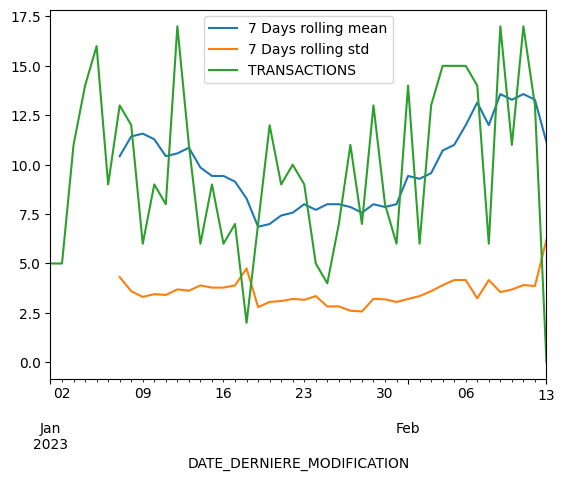

In [258]:
# print(df['CODE_PDV'].value_counts())
plot(pdv1)

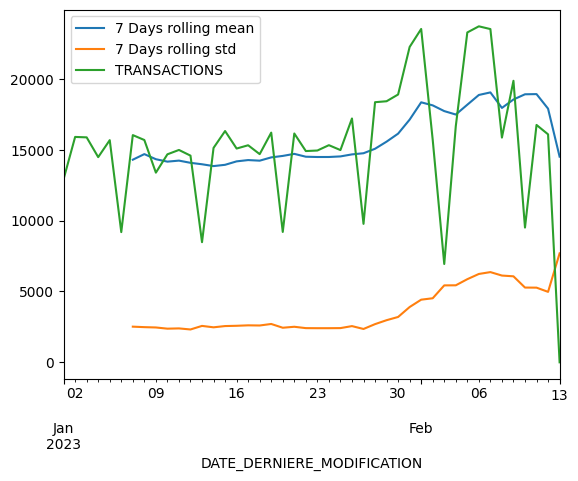

In [259]:
plot(overall1)